In [2]:
import marimo as mo
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import FastICA
from scipy.optimize import linear_sum_assignment
import itertools

A Linear Non-Gaussian Acyclic Model for Causal Discovery: https://www.cs.helsinki.fi/group/neuroinf/lingam/JMLR06.pdf

## Identifiability of Non-Gaussianity

$$
\begin{bmatrix} x_1 \\ x_2 \end{bmatrix}
= \begin{bmatrix} 0 & 0 \\ 0.8 & 0 \end{bmatrix}
\begin{bmatrix} x_1 \\ x_2 \end{bmatrix}
+ \begin{bmatrix} e_1 \\ e_2 \end{bmatrix}
$$

$$ \mathbf{x} =  B\mathbf{x}+\mathbf{e} \implies (I - B)\mathbf{x} = \mathbf{e} \implies \mathbf{x} = (I - B)^{-1}\mathbf{e}$$

In [3]:
def sample_dist(n_samples, dist="uniform"):
    if dist == "uniform":
        return np.random.uniform(low=-1, high=1, size=n_samples)
    elif dist == "exponential":
        return np.random.exponential(scale=1.0, size=n_samples) - 1.0
    elif dist == "laplace":
        return np.random.laplace(loc=0.0, scale=1.0, size=n_samples)
    elif dist == "normal":
        return np.random.normal(loc=0, scale=1, size=n_samples)

    raise ValueError(f"Dont know about distribution {dist}")

def gen_x(B, e):
    n = B.shape[0]
    I = np.eye(n)
    x = np.linalg.inv(I - B) @ e
    return x    

In [4]:
def plot_xs(ax, B, n_samples=1000, dist1="unif", dist2="unif"):
    e1 = sample_dist(n_samples, dist1)
    e2 = sample_dist(n_samples, dist2)

    e = np.vstack([e1, e2])
    x = gen_x(B, e)
    x1 = x[0]
    x2 = x[1]

    ax.scatter(x1, x2)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")    


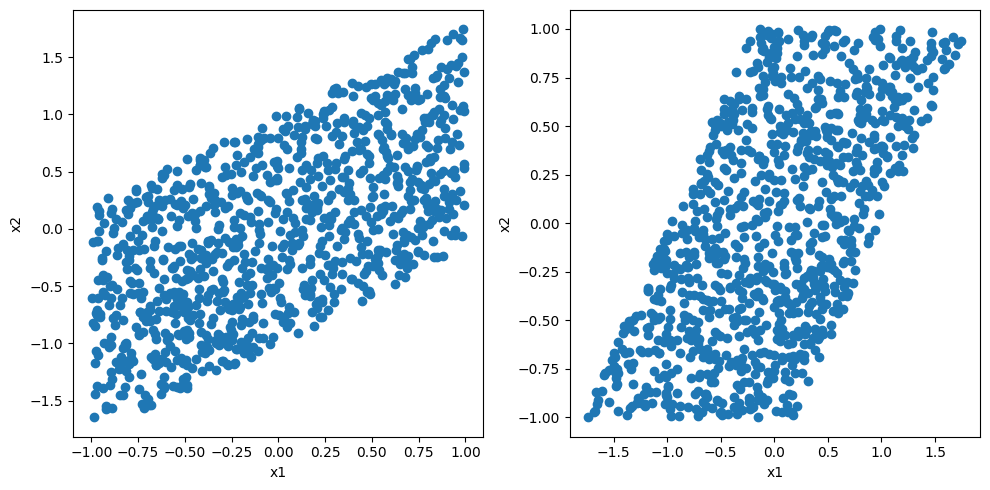

In [5]:
n_samples = 1000
B1 = np.array([[0, 0], [0.8, 0]])
B2 = np.array([[0, 0.8], [0, 0]])
e1_dist = "uniform"
e2_dist = "uniform"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

plot_xs(ax1, B1, n_samples=n_samples, dist1=e1_dist, dist2=e2_dist)
plot_xs(ax2, B2, n_samples=n_samples, dist1=e1_dist, dist2=e2_dist)

plt.tight_layout()
plt.show()

## Lingam Discovery Algorithm

Section 4, Algorithm A: https://www.cs.helsinki.fi/group/neuroinf/lingam/JMLR06.pdf

Adapted from https://github.com/cdt15/lingam

In [6]:
def est_causal_order(B):
    # Exhaustive permutation search. Is O(d!)
    d = B.shape[0]
    perms = list(itertools.permutations(range(d)))
    best_score = float("inf")
    best_perm = None

    for perm in perms:
        P = np.eye(d)[list(perm)]
        B_perm = P @ B @ P.T
        score = np.sum(np.triu(B_perm)**2)
        if score < best_score:
            best_perm = perm
            best_score = score

    P_best = np.eye(d)[list(best_perm)]
    return P_best

In [7]:
# Setup the data. Want to learn B

B = np.array([
    [0, 0.8, 0.1], 
    [0, 0, 0.2],
    [0, 0, 0]
])

e1 = sample_dist(n_samples=n_samples, dist="laplace")
e2 = sample_dist(n_samples=n_samples, dist="uniform")
e3 = sample_dist(n_samples=n_samples, dist="exponential")


e = np.vstack([e1, e2, e3])

X = gen_x(B, e).T

# Normalise x
X = X - X.mean(axis=0, keepdims=True)


ica = FastICA(whiten="unit-variance", random_state=42)
ica.fit(X)
W_ica = ica.components_


# Step 2. Find only permutation of cols which yields matrix without 0 on diagonal.
# In practice, all elements will be nearly non-zero. Hence minimise sum of |1/ W_{ii}|

_, col_ind = linear_sum_assignment(1 / np.abs(W_ica))

W_ica[col_ind] = W_ica

diag_elems = np.diag(W_ica)

W_est = W_ica / diag_elems[:, np.newaxis]

B_est =  np.eye(W_est.shape[0]) - W_est

# Step 5. Causal Order estimation
# Want P s.t. B = P B_est P^T  is approx. lower triangular
# minimise sum of B_ij^2 for i<=j (sum of upper triangle including diag)

P = est_causal_order(B_est)
print(B_est)
print(P)

B_est = P @ B_est @ P.T

[[ 0.          0.80550817  0.12334355]
 [ 0.00972905  0.          0.21697926]
 [-0.02760351  0.02683205  0.        ]]
[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


# Causal Chambers

In [8]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from lingam import ICALiNGAM
from lingam import DirectLiNGAM

from causalchamber.datasets import Dataset


Fetching list of available datasets from https://causalchamber.s3.eu-central-1.amazonaws.com/downloadables/directory.yaml ... done.
If you use our datasets or simulators for your work please consider citing:

﻿@article{gamella2025chamber,
  author={Gamella, Juan L. and Peters, Jonas and B{"u}hlmann, Peter},
  title={Causal chambers as a real-world physical testbed for {AI} methodology},
  journal={Nature Machine Intelligence},
  doi={10.1038/s42256-024-00964-x},
  year={2025},
}



In [15]:
# Download the dataset and store it, e.g., in the current directory
dataset = Dataset('lt_crl_benchmark_v1', root='./', download=True)

# Load the observations and images from an experiment (see experiment names below)
experiment = dataset.get_experiment(name='uniform') #uniform_synth_det
observations = experiment.as_pandas_dataframe()
images = experiment.as_image_array(size='64')
print(observations.head())

Dataset lt_crl_benchmark_v1 found in "lt_crl_benchmark_v1".
       timestamp  config  counter  flag  intervention    red  green   blue  \
0  438464.329963  camera      0.0   0.0           1.0  173.0  170.0  132.0   
1  438466.496309  camera      1.0   0.0           1.0   91.0   33.0   49.0   
2  438468.638635  camera      2.0   0.0           1.0  192.0  108.0  189.0   
3  438471.452606  camera      3.0   0.0           1.0   60.0  167.0  193.0   
4  438473.950781  camera      4.0   0.0           1.0  201.0  102.0  117.0   

   osr_c  v_c  ...  t_vis_2  t_ir_3  t_vis_3  camera  v_board  v_reg  \
0    1.0  5.0  ...      3.0     3.0      3.0     1.0   1022.0  702.0   
1    1.0  5.0  ...      3.0     3.0      3.0     1.0   1023.0  781.0   
2    1.0  5.0  ...      3.0     3.0      3.0     1.0   1023.0  804.0   
3    1.0  5.0  ...      3.0     3.0      3.0     1.0   1023.0  783.0   
4    1.0  5.0  ...      3.0     3.0      3.0     1.0   1023.0  792.0   

   aperture  iso  shutter_speed    ima

In [23]:
data = observations.select_dtypes(include=[np.number]) #.dropna()
print(data.columns)
#print(data.head())

my_vars = [
    'red', 'green', 'blue',
    #'current', 
    #'pol_1', 'pol_2', 
    'angle_1', 'angle_2', 
    'ir_1',
       #'vis_1', 
    'ir_2', 
    #'vis_2', 
    'ir_3', 
    #'vis_3', 
]
data = data[my_vars].copy()
#print(data.head())
var_names = list(data.columns)
print(var_names)


#X = data.values
scaler = StandardScaler()
X = scaler.fit_transform(data.values)

# 2. Fit ICA-LiNGAM
ica_model = ICALiNGAM(max_iter=50000)
ica_model.fit(X)
adj_ica = ica_model.adjacency_matrix_  # shape (n_vars, n_vars)
print("ICA Lingam done")
print(adj_ica)
# 3. Fit DirectLiNGAM
direct_model = DirectLiNGAM(measure="pwling")
direct_model.fit(X)
adj_direct = direct_model.adjacency_matrix_
print(adj_direct)

Index(['timestamp', 'counter', 'flag', 'intervention', 'red', 'green', 'blue',
       'osr_c', 'v_c', 'current', 'pol_1', 'pol_2', 'osr_angle_1',
       'osr_angle_2', 'v_angle_1', 'v_angle_2', 'angle_1', 'angle_2', 'ir_1',
       'vis_1', 'ir_2', 'vis_2', 'ir_3', 'vis_3', 'l_11', 'l_12', 'l_21',
       'l_22', 'l_31', 'l_32', 'diode_ir_1', 'diode_vis_1', 'diode_ir_2',
       'diode_vis_2', 'diode_ir_3', 'diode_vis_3', 't_ir_1', 't_vis_1',
       't_ir_2', 't_vis_2', 't_ir_3', 't_vis_3', 'camera', 'v_board', 'v_reg',
       'iso'],
      dtype='object')
['red', 'green', 'blue', 'angle_1', 'angle_2', 'ir_1', 'ir_2', 'ir_3']
ICA Lingam done
[[0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         

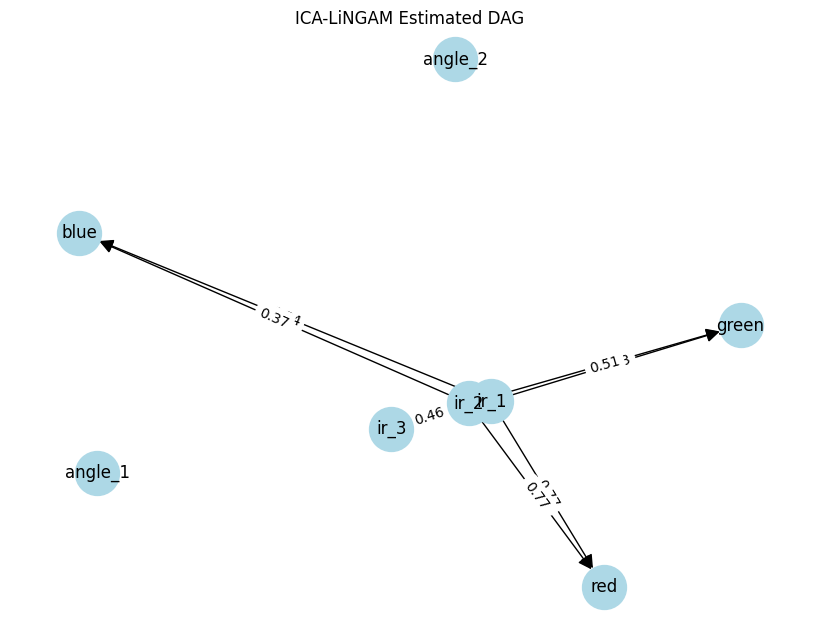

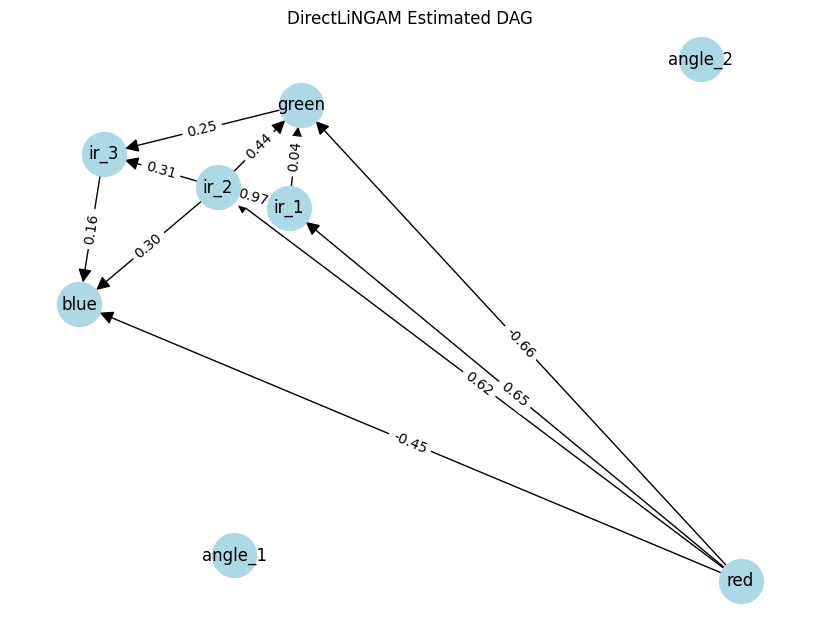

In [28]:
# 4. Helper to plot DAG from adjacency matrix
def plot_dag(adj_matrix, var_names, title, threshold=0.1):
    """
    adj_matrix: numpy array shape (n, n), weight[i,j] is effect from i -> j
    var_names: list of column names, length n
    threshold: only include edges with |weight| > threshold
    """
    G = nx.DiGraph()
    G.add_nodes_from(var_names)
    n = len(var_names)
    for i in range(n):
        for j in range(n):
            w = adj_matrix[i, j]
            if abs(w) > threshold:
                G.add_edge(var_names[i], var_names[j], weight=w)
    # Layout and plot
    pos = nx.spring_layout(G, seed=44)  # fix seed for reproducibility
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, arrowsize=20, node_color='lightblue', node_size=1000)
    # Edge labels = weights
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title(title)
    #plt.tight_layout()
    plt.show()

# 5. Plot both DAGs
# You may tune the threshold based on magnitudes you observe.
plot_dag(adj_ica, var_names, 'ICA-LiNGAM Estimated DAG', threshold=0.02)
plot_dag(adj_direct, var_names, 'DirectLiNGAM Estimated DAG', threshold=0.02)

In [22]:
from causalchamber.ground_truth import graph
graph(chamber="lt", configuration="standard")


,red,green,blue,osr_c,v_c,current,pol_1,pol_2,osr_angle_1,osr_angle_2,...,diode_ir_2,diode_vis_2,diode_ir_3,diode_vis_3,t_ir_1,t_vis_1,t_ir_2,t_vis_2,t_ir_3,t_vis_3
red,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
green,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
blue,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
osr_c,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
v_c,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
current,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pol_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pol_2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
osr_angle_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
osr_angle_2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
from scipy.stats import kurtosis
import math

kurt_vals = data.apply(lambda col: kurtosis(col.dropna(), fisher=True))
print("Excess kurtosis per column:")
print(kurt_vals)


Excess kurtosis per column:
red     -1.170472
green   -1.209274
blue    -1.212498
ir_1    -0.574317
ir_2    -0.566246
dtype: float64


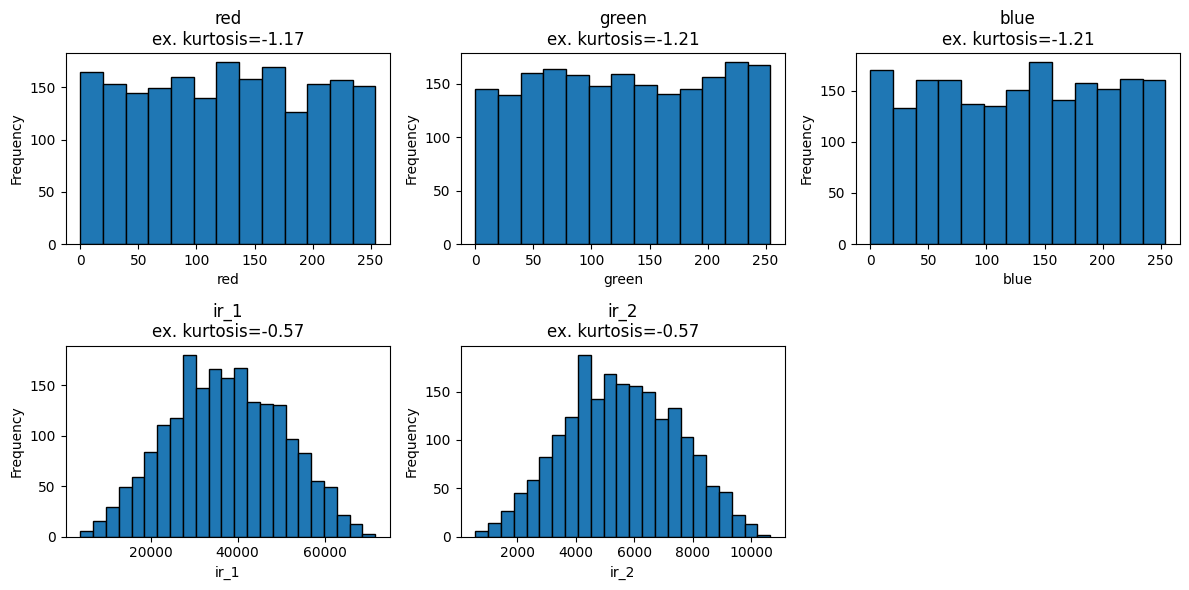

In [14]:
# Determine subplot grid size
n = len(data.columns)
n_cols = int(math.ceil(math.sqrt(n)))
n_rows = int(math.ceil(n / n_cols))

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
axes = axes.flatten()

# Plot each histogram
for ax, col in zip(axes, data.columns):
    vals = data[col].dropna()
    ax.hist(vals, bins='auto', edgecolor='black')
    ax.set_title(f"{col}\nex. kurtosis={kurt_vals[col]:.2f}")
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")

# Hide any unused subplots
for ax in axes[n:]:
    ax.set_visible(False)

plt.tight_layout()
# Save to file
fig.savefig("all_histograms.png", dpi=150)
plt.show()

In [3]:
import numpy as np
import pandas as pd

# Variable names
var_names = ['red', 'green', 'blue', 'angle_1', 'angle_2', 'ir_1', 'ir_2', 'ir_3']

# Adjacency arrays as before
adj_ica = np.array([
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.77175857, 0.52501704, 0.34266159, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.77373373, 0.50516727, 0.36780414, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.00390489, 0.0, 0.0, 0.0, 0.0, 0.0, 0.45687113, 0.0]
])
adj_direct = np.array([
    [0.0, -0.65659448, -0.45275952, 0.0, 0.0, 0.65183433, 0.62256734, 0.0],
    [0.0,  0.0,        0.0,        0.0, 0.0, 0.0,        0.0,        0.24518835],
    [0.0,  0.0,        0.0,        0.0, 0.0, 0.0,        0.0,        0.0],
    [0.0,  0.0,        0.0,        0.0, 0.0, 0.0,        0.0,        0.0],
    [0.0,  0.0,        0.0,        0.0, 0.0, 0.0,        0.0,        0.0],
    [0.0,  0.03540645, -0.014542,  0.0, 0.0, 0.0,        0.96956996, 0.0],
    [0.0,  0.43717743,  0.29841726,0.0, 0.0, 0.0,        0.0,        0.30523772],
    [0.0,  0.0,         0.15897608,0.0, 0.0, 0.0,        0.0,        0.0]
])

# Create DataFrames
df_ica = pd.DataFrame(adj_ica, index=var_names, columns=var_names)
df_direct = pd.DataFrame(adj_direct, index=var_names, columns=var_names)

# Round values for readability
df_ica_r = df_ica.round(3)
df_direct_r = df_direct.round(3)

# In a script or terminal:
print("ICA-LiNGAM adjacency matrix:")
print(df_ica_r)
print("\nDirectLiNGAM adjacency matrix:")
print(df_direct_r)

# In a Jupyter notebook, you can also:
from IPython.display import display
display(df_ica_r)
display(df_direct_r)

# Optionally, export to CSV:
# df_ica_r.to_csv("adj_ica.csv")
# df_direct_r.to_csv("adj_direct.csv")


ICA-LiNGAM adjacency matrix:
           red  green   blue  angle_1  angle_2  ir_1   ir_2  ir_3
red      0.000  0.000  0.000      0.0      0.0   0.0  0.000   0.0
green    0.000  0.000  0.000      0.0      0.0   0.0  0.000   0.0
blue     0.000  0.000  0.000      0.0      0.0   0.0  0.000   0.0
angle_1  0.000  0.000  0.000      0.0      0.0   0.0  0.000   0.0
angle_2  0.000  0.000  0.000      0.0      0.0   0.0  0.000   0.0
ir_1     0.772  0.525  0.343      0.0      0.0   0.0  0.000   0.0
ir_2     0.774  0.505  0.368      0.0      0.0   0.0  0.000   0.0
ir_3     0.004  0.000  0.000      0.0      0.0   0.0  0.457   0.0

DirectLiNGAM adjacency matrix:
         red  green   blue  angle_1  angle_2   ir_1   ir_2   ir_3
red      0.0 -0.657 -0.453      0.0      0.0  0.652  0.623  0.000
green    0.0  0.000  0.000      0.0      0.0  0.000  0.000  0.245
blue     0.0  0.000  0.000      0.0      0.0  0.000  0.000  0.000
angle_1  0.0  0.000  0.000      0.0      0.0  0.000  0.000  0.000
angle_2  0.0  0

,red,green,blue,angle_1,angle_2,ir_1,ir_2,ir_3
red,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.0
green,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.0
blue,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.0
angle_1,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.0
angle_2,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.0
ir_1,0.772,0.525,0.343,0.0,0.0,0.0,0.000,0.0
ir_2,0.774,0.505,0.368,0.0,0.0,0.0,0.000,0.0
ir_3,0.004,0.000,0.000,0.0,0.0,0.0,0.457,0.0


,red,green,blue,angle_1,angle_2,ir_1,ir_2,ir_3
red,0.0,-0.657,-0.453,0.0,0.0,0.652,0.623,0.000
green,0.0,0.000,0.000,0.0,0.0,0.000,0.000,0.245
blue,0.0,0.000,0.000,0.0,0.0,0.000,0.000,0.000
angle_1,0.0,0.000,0.000,0.0,0.0,0.000,0.000,0.000
angle_2,0.0,0.000,0.000,0.0,0.0,0.000,0.000,0.000
ir_1,0.0,0.035,-0.015,0.0,0.0,0.000,0.970,0.000
ir_2,0.0,0.437,0.298,0.0,0.0,0.000,0.000,0.305
ir_3,0.0,0.000,0.159,0.0,0.0,0.000,0.000,0.000
